# Extended Graham scan algorithm

Use the cell below for all python code needed to realise the extended Graham scan algorithm (including any auxiliary data structures and functions you might need). The `extendedgrahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [27]:
def centroid(triangle):
    # Reference to https://www.mathopenref.com/coordcentroid.html 
    return [sum([i[0] for i in triangle]) / 3, sum([i[1] for i in triangle]) / 3]

def slope(p1, p2):
    return (p1[1] - p2[1]) / (p1[0] - p2[0]) if p1[0] - p2[0] != 0 else math.inf

def collinear(points):
    # The property of collinear points is that given a set of points {s1, s2 , ... , sn}, the gradient between any two points are equal 
    s1, s2, s3 = slope(points[0], points[1]), slope(points[0], points[2]), slope(points[1], points[2])
    return s1 == s2 and s2 == s3 and s1 == s3

def pyth(p1, p2):
    # Calculates the distance between two points in the R^2 vector space using Pythagorous' 
    return math.sqrt(math.pow((p1[0] - p2[0]), 2) + math.pow((p1[1] - p2[1]), 2))

def changerange(theta):
    # The paper used the range of radians to be between [0, 2pi), but the math library uses [-pi, pi) 
    return theta if theta >= 0 else math.tau + theta

def midtest(points):
    # Finds the midpoint between 3 collinear points, returns two points which has the longest distance 
    distances = [pyth(points[0], points[1]), pyth(points[0], points[2]), pyth(points[1], points[2])]
    if max(distances) == distances[0]:
        return [points[0], points[1]]
    return [points[0], points[2]] if max(distances) == distances[1] else [points[1], points[2]]

def calcP(inputSet):
    # Finds the point P 
    while collinear(inputSet[:3:]) and len(inputSet) > 3:
        inputSet = midtest(inputSet[:3:]) + inputSet[3::]
    return centroid(inputSet[:3:])

def polar(coordinates):
    return [pyth(coordinates, [0,0]), changerange(math.atan2(coordinates[1], coordinates[0]))]

def cartesianList(polarHull, P):
    return [[round(j) for j in cartesian(i, P)] for i in polarHull]

def resetOrigin(P, inputSet):
    return [polar([i[0]-P[0], i[1]-P[1]]) for i in inputSet]

def cartesian(coordinates, P):
    return [(coordinates[0] * math.cos(coordinates[1])) + P[0], (coordinates[0] * math.sin(coordinates[1])) + P[1]]

def merge(L,R):
    ret_array = []
    l_index = 0
    r_index = 0
    while len(ret_array) < (len(L) + len(R)):
        if l_index == len(L):
            ret_array += R[r_index:]
            break
        elif r_index == len(R):
            ret_array += L[l_index:]
            break
        if L[l_index][1] < R[r_index][1]:
            ret_array.append(L[l_index])
            l_index += 1
        elif L[l_index][1] >= R[r_index][1]:
            ret_array.append(R[r_index])
            r_index += 1
    return ret_array

def msort(inputSet):
    # Sort the set of coordinates using merge sort
    if len(inputSet) == 1:
        return inputSet
    mid = len(inputSet) // 2
    L = msort(inputSet[:mid])
    R = msort (inputSet[mid:])
    return merge(L,R)
    

def maxr(inputSet, threshold=1e-8):
    # This function selects the polar coordinate with same angle as others but has the largest magnitude
    # A threshold default argument has been added to prevent floating point arithmetic errors
    polar, curtheta = [], -math.inf
    for i in inputSet:
        if abs(i[1] - curtheta) < threshold:
            polar[-1][0] = max(i[0], polar[-1][0])
        else:
            polar.append(i)
            curtheta = i[1]
    return polar

def deletenomag(inputSet):
    # This function removes the polar coordinates with no magnitude
    return [i for i in inputSet if i[0] != 0]

def calcAngle(coor1, coor2):
    # Note that c is the side oppositing the angle to be found using the cosine rule
    a, b, c = coor1[0], pyth(cartesian(coor1, [0, 0]), cartesian(coor2, [0, 0])), coor2[0]
    try:
        return math.acos((a**2 + b**2 - c**2) / (2*a*b))
    except ValueError:  
        '''
        The only possible way to get a ValueError is when a, b and c cannot form a triangle.  Notice that under the context
        of this function the only possible way to get a ValueError is when | arg(coor2) - arg(coor1) | is an element of {0, -pi}.
        Since it is not possible that it equals 0, since it would have been deleted from the function maxr, therefore the only
        possible way valuation is -pi.
        '''
        return -math.pi
    
def enclosedCoords(inputSet):
    #Remove points within inputSet that are enclosed by the NorthWest, NorthEast, SouthWest, SouthEast points
    xmax = [-math.inf,0]
    xmin = [math.inf,0]
    ymax = [0,-math.inf]
    ymin = [0,math.inf]
    for coord in inputSet:
        x = coord[0]
        y = coord[1]
        if max(x,xmax[0]) == x:
            xmax = coord
        if min(x,xmin[0]) == x:
            xmin = coord
        if max(y,ymax[1]) == y:
            ymax = coord
        if min(y,ymin[1]) == y:
            ymin = coord
    '''print(f"xmax: {xmax}")
    print(f"xmin: {xmin}")
    print(f"ymax: {ymax}")
    print(f"ymin: {ymin}")'''
    return [xmax,ymax,xmin,ymin]

def triangleArea(point1, point2,point3):
    #https://ncalculators.com/geometry/triangle-area-by-3-points.htm
    return abs(point1[0]*(point2[1]-point3[1]) + point2[0]*(point3[1]-point1[1]) + point3[0]*(point1[1]-point2[1])) /2

def notinRegion(point,enclose,area):
    total = []
    total.append(triangleArea(enclose[0],enclose[1],point))
    total.append(triangleArea(enclose[1],enclose[2],point))
    total.append(triangleArea(enclose[2],enclose[3],point))
    total.append(triangleArea(enclose[3],enclose[0],point))
    return (sum(total) != area)
    

def wipePoints(inputSet):
    points = enclosedCoords(inputSet)
    enclosedArea = triangleArea(points[0],points[1],points[2]) + triangleArea(points[2],points[3],points[0])
    return [p for p in inputSet if notinRegion(p,points,enclosedArea)] + points
 
   
def trace(inputSet):
    pointer, tracker = 1, [i for i in inputSet]
    # Tracker is explicitly defined this way to prevent affecting the inputSet during running
    while tracker != []:
        p1, p2, p3 = (pointer-1) % len(inputSet), pointer % len(inputSet), (pointer+1) % len(inputSet)
        if calcAngle(inputSet[p2], inputSet[p1]) + calcAngle(inputSet[p2], inputSet[p3]) >= math.pi:
            toremove = inputSet[p2]
            inputSet.remove(toremove)
            pointer -= 1
        else:
            toremove = inputSet[p1]
            pointer += 1
        try:
            tracker.remove(toremove)
        except ValueError:
            pass
    return inputSet

def extendedgrahamscan(inputSet):
    wipedSet = wipePoints(inputSet)
    P = calcP(wipedSet)
    polarSet = msort(resetOrigin(P, wipedSet))
    polarSet = deletenomag(maxr(polarSet))
    polarHull = trace(polarSet)
    return cartesianList(polarHull, P)

Use the cell below for all python code needed to generate test data points (both random and those representing worst-case scenario).

In [28]:
import random

#code for random data generation
def randGeneration(n, lb=0, ub=32767):
    return [[random.randint(lb, ub), random.randint(lb, ub)] for i in range(n)]

#code for worst case data generation
def randWorstGeneration(n):
    return [[0,0] for i in range(n)]


Use the cell below for all python code needed to test the `extendedgrahamscan()` function on the data generated above.

In [29]:
import timeit

#test code
def test(n, worstCase=False, repeats=1):
    timetaken = [0 for i in range(len(n))]
    for j in range(repeats):
        for i in n:
            data = randWorstGeneration(int(i)) if worstCase else randGeneration(int(i))
            start_time = timeit.default_timer()
            _ = extendedgrahamscan(data)
            timetaken[n.index(i)] = timeit.default_timer() - start_time
    return [i/repeats for i in timetaken]

n = [1e2, 5e2, 1e3, 5e3, 1e4, 1.5e4, 2e4]
r_timetaken = test(n)
#w_timetaken = test(n, worstCase = True)
print("Average case: ",r_timetaken)
#print("Worst case: ",w_timetaken)

Average case:  [0.0007978000003276975, 0.004727900000034424, 0.016021500000533706, 0.13065319999986968, 0.32193740000002435, 1.304284099999677, 1.701064700000643]


*Optional*: Feel free to use the code below on small datasets (e.g., N = 10) to visually inspect whether the algorithm has been implemented correctly. The fragment below assumes both `inputSet` and `outputSet` to be lists of 2D points, with each point being a list of 2 elements (e.g., `[[x1,y1], [x2,y2], ..., [x_k,y_k]]`)

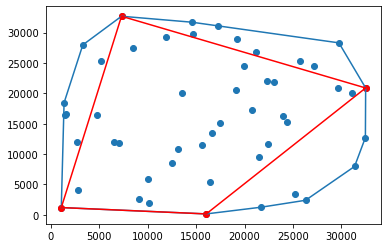

In [30]:
import matplotlib.pyplot as plt

#inputSet = [[1,1], [2,2], [3,3], [4,4], [1,4], [3,1], [1,5], [2,4], [3,5]]
#outputSet = [[1,1], [3,1], [4,4], [3,5], [1,5]]

inputSet = randGeneration(50)
outputSet = extendedgrahamscan(inputSet)
plt.figure()

#first do a scatter plot of the inputSet
input_xs, input_ys = zip(*inputSet)
plt.scatter(input_xs, input_ys)

bound = enclosedCoords(inputSet)
bound_xs, bound_ys = zip(*bound)
plt.scatter(bound_xs, bound_ys,color = "red")

#then do a polygon plot of the computed covex hull
outputSet.append(outputSet[0]) #first create a 'closed loop' by adding the first point at the end of the list
output_xs, output_ys = zip(*outputSet)
plt.plot(output_xs, output_ys) 

bound.append(bound[0])
output_xs, output_ys = zip(*bound)
plt.plot(output_xs, output_ys,color = "red") 


plt.show() 
